In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec
import json

In [64]:
df = pd.read_csv(r"C:\Users\honya\Documents\GitHub\etf_predictor\data\features\all_features_enhanced.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("DF loaded:", df.shape)
print("Date range:", df['Date'].min(), "to", df['Date'].max())

DF loaded: (531345, 142)
Date range: 2000-01-03 00:00:00 to 2026-01-28 00:00:00


In [65]:
train_df = df[df['Date'] < "2010-01-01"].copy()
val_df = df[(df['Date'] >= "2010-01-01") & (df['Date'] < "2012-01-01")].copy()
test_df = df[df['Date'] >= "2000-01-01"].copy()

tickers = sorted(df["ticker"].unique())

print("Train:", train_df.shape, "| Val:", val_df.shape, "| Test:", test_df.shape)

Train: (166019, 142) | Val: (39544, 142) | Test: (531345, 142)


In [66]:
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# Recalculate 200-day MA from scratch
print("Calculating 200-day moving average...")
df['ma_200'] = df.groupby('ticker')['Close'].transform(
    lambda x: x.rolling(window=200, min_periods=200).mean()
)

# Recalculate binary feature properly
print("Calculating above_ma_200 feature...")
df['above_ma_200'] = (df['Close'] > df['ma_200']).astype(float)
df['above_ma_200'] = df['above_ma_200'].fillna(0)

Calculating 200-day moving average...
Calculating above_ma_200 feature...


In [67]:
def backtest_200ma_strategy(test_df, tickers, top_k=10, vol_percentile=95, min_train_quarters=20):
    """
    200-MA baseline strategy with SAME filters as GNN for fair comparison
    """
    portfolio_returns = []
    
    rebalance_dates = pd.date_range(
        start=test_df['Date'].min(), 
        end=test_df['Date'].max(), 
        freq='Q'
    )
    
    for i, prediction_date in enumerate(rebalance_dates):
        
        # Skip if not enough training quarters
        if i < min_train_quarters:
            continue
        
        # Find closest available date
        date_candidates = test_df[
            (test_df['Date'] >= prediction_date - pd.Timedelta(days=7)) &
            (test_df['Date'] <= prediction_date)
        ]['Date'].unique()
        
        if len(date_candidates) == 0:
            continue
        
        closest_date = max(date_candidates)
        pred_data = test_df[test_df['Date'] == closest_date].copy()
        
        if pred_data.empty:
            continue
        
        # Get volatility for each stock
        stock_volatilities = {}
        for t in tickers:
            ticker_rows = pred_data[pred_data['ticker'] == t]
            if len(ticker_rows) > 0 and 'volatility_20' in pred_data.columns:
                vol = ticker_rows['volatility_20'].iloc[0]
                stock_volatilities[t] = vol if not np.isnan(vol) else np.inf
            else:
                stock_volatilities[t] = np.inf
        
        # Calculate volatility threshold
        valid_vols = [v for v in stock_volatilities.values() if v != np.inf]
        if len(valid_vols) > 0:
            vol_threshold = np.percentile(valid_vols, vol_percentile)
        else:
            vol_threshold = np.inf
        
        # Calculate MA strength signal
        ma_signals = {}
        for t in tickers:
            ticker_rows = pred_data[pred_data['ticker'] == t]
            
            if len(ticker_rows) > 0:
                row = ticker_rows.iloc[0]
                
                # Check if stock is above MA
                if 'above_ma_200' in row.index and 'Close' in row.index and 'ma_200' in row.index:
                    above_ma = row['above_ma_200']
                    close = row['Close']
                    ma_200 = row['ma_200']
                    
                    # Only consider stocks above MA
                    if above_ma == 1.0 and not np.isnan(ma_200) and ma_200 > 0:
                        # Calculate strength: % above MA
                        strength = ((close - ma_200) / ma_200) * 100
                        ma_signals[t] = strength
        
        # Apply filters
        vol_series = pd.Series(stock_volatilities)
        ma_signal_series = pd.Series(ma_signals)
        
        # Stock must pass BOTH filters
        safe_vol_mask = vol_series < vol_threshold
        has_ma_signal_mask = ma_signal_series.notna()
        
        # Get candidates
        passing_tickers = []
        for t in tickers:
            if safe_vol_mask.get(t, False) and has_ma_signal_mask.get(t, False):
                passing_tickers.append(t)
        
        candidates = ma_signal_series[passing_tickers]
        
        # Select top K by MA strength
        if len(candidates) > 0:
            sorted_candidates = candidates.sort_values(ascending=False)
            top_stocks = sorted_candidates.head(top_k).index.tolist()
        else:
            top_stocks = []
        
        # Calculate portfolio return
        if len(top_stocks) > 0:
            returns = []
            for ticker in top_stocks:
                ticker_return = test_df[
                    (test_df['Date'] == closest_date) & 
                    (test_df['ticker'] == ticker)
                ]['target_3m'].values
                
                if len(ticker_return) > 0 and not np.isnan(ticker_return[0]):
                    returns.append(ticker_return[0])
            
            portfolio_return = np.mean(returns) if returns else 0
        else:
            portfolio_return = 0
        
        portfolio_returns.append(portfolio_return)
        
        print(f"Date: {closest_date.date()} | "
              f"Vol Filter: {sum(safe_vol_mask)}/{len(tickers)} | "
              f"MA Filter: {len(ma_signals)}/{len(tickers)} | "
              f"Both: {len(candidates)}/{len(tickers)} | "
              f"Selected: {len(top_stocks)} | "
              f"Return: {portfolio_return:.4f}")
    
    return portfolio_returns

In [68]:
ma_returns = backtest_200ma_strategy(
    test_df=df,
    tickers=tickers,
    top_k=10,
    vol_percentile=90,
    min_train_quarters=20
)

C:\Users\honya\AppData\Local\Temp\ipykernel_13796\805543884.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebalance_dates = pd.date_range(


Date: 2005-03-31 | Vol Filter: 58/100 | MA Filter: 39/100 | Both: 36/100 | Selected: 10 | Return: 0.1038
Date: 2005-06-30 | Vol Filter: 59/100 | MA Filter: 46/100 | Both: 40/100 | Selected: 10 | Return: 0.1487
Date: 2005-09-30 | Vol Filter: 60/100 | MA Filter: 45/100 | Both: 38/100 | Selected: 10 | Return: 0.2842
Date: 2005-12-30 | Vol Filter: 60/100 | MA Filter: 52/100 | Both: 46/100 | Selected: 10 | Return: 0.0930
Date: 2006-03-31 | Vol Filter: 60/100 | MA Filter: 53/100 | Both: 46/100 | Selected: 10 | Return: -0.1585
Date: 2006-06-30 | Vol Filter: 60/100 | MA Filter: 35/100 | Both: 32/100 | Selected: 10 | Return: -0.0310
Date: 2006-09-29 | Vol Filter: 60/100 | MA Filter: 42/100 | Both: 39/100 | Selected: 10 | Return: 0.0690
Date: 2006-12-29 | Vol Filter: 60/100 | MA Filter: 46/100 | Both: 43/100 | Selected: 10 | Return: -0.0122
Date: 2007-03-30 | Vol Filter: 60/100 | MA Filter: 44/100 | Both: 41/100 | Selected: 10 | Return: 0.0837
Date: 2007-06-29 | Vol Filter: 62/100 | MA Filter: 5

In [69]:
with open('gnn_results.json', 'r') as f:
    gnn_metrics = json.load(f)

gnn_annualized_return = gnn_metrics['annualized_return']
gnn_sharpe = gnn_metrics['sharpe']
gnn_sortino = gnn_metrics['sortino']
gnn_volatility_annual = gnn_metrics['volatility_annual']
gnn_downside_vol_annual = gnn_metrics['downside_vol_annual']
gnn_max_dd = gnn_metrics['max_dd']
gnn_total_return = gnn_metrics['total_return']
gnn_n_quarters = gnn_metrics['n_quarters']

In [70]:
# ============================================================================
# CALCULATE 200-MA METRICS
# ============================================================================
ma_returns_arr = np.array(ma_returns)

# Basic stats
ma_mean = np.mean(ma_returns_arr)
ma_std = np.std(ma_returns_arr, ddof=1)

# Downside volatility
ma_downside = ma_returns_arr[ma_returns_arr < 0]
ma_downside_std = np.std(ma_downside, ddof=1) if len(ma_downside) > 1 else ma_std

# Total and annualized return
ma_total_return = np.prod(1 + ma_returns_arr) - 1
ma_n_years = len(ma_returns_arr) / 4
ma_annualized_return = (1 + ma_total_return)**(1/ma_n_years) - 1

# Annualized volatility
ma_annual_vol = ma_std * np.sqrt(4)
ma_downside_vol = ma_downside_std * np.sqrt(4)

# Sharpe and Sortino
ma_sharpe = (ma_mean / ma_std) * np.sqrt(4) if ma_std > 0 else 0
ma_sortino = (ma_mean / ma_downside_std) * np.sqrt(4) if ma_downside_std > 0 else 0

# Drawdown
ma_cum = np.cumprod(1 + ma_returns_arr)
ma_running_max = np.maximum.accumulate(ma_cum)
ma_drawdown = (ma_cum - ma_running_max) / ma_running_max
ma_max_dd = ma_drawdown.min()

# Cumulative return
ma_cumulative = ma_cum[-1]

In [71]:
print(f"\n{'Metric':<25} {'GNN Strategy':<20} {'200-MA Baseline':<20} {'Difference':<15}")

print(f"{'Total Return':<25} {gnn_total_return*100:>18.1f}% {ma_total_return*100:>18.1f}% {(gnn_total_return - ma_total_return)*100:>13.1f}%")
print(f"{'Annualized Return':<25} {gnn_annualized_return*100:>18.1f}% {ma_annualized_return*100:>18.1f}% {(gnn_annualized_return - ma_annualized_return)*100:>13.1f}%")
print(f"{'Sharpe Ratio':<25} {gnn_sharpe:>18.2f} {ma_sharpe:>18.2f} {gnn_sharpe - ma_sharpe:>13.2f}")
print(f"{'Sortino Ratio':<25} {gnn_sortino:>18.2f} {ma_sortino:>18.2f} {gnn_sortino - ma_sortino:>13.2f}")
print(f"{'Volatility (Annual)':<25} {gnn_volatility_annual*100:>17.1f}% {ma_annual_vol*100:>17.1f}% {(gnn_volatility_annual - ma_annual_vol)*100:>12.1f}%")
print(f"{'Downside Vol (Annual)':<25} {gnn_downside_vol_annual*100:>17.1f}% {ma_downside_vol*100:>17.1f}% {(gnn_downside_vol_annual - ma_downside_vol)*100:>12.1f}%")
print(f"{'Max Drawdown':<25} {gnn_max_dd*100:>17.1f}% {ma_max_dd*100:>17.1f}% {(gnn_max_dd - ma_max_dd)*100:>12.1f}%")
print(f"{'Cumulative Return':<25} {gnn_total_return*100:>17.1f}% {(ma_cumulative-1)*100:>17.1f}% {(gnn_total_return - (ma_cumulative-1))*100:>12.1f}%")

print("\n" + "="*80)
print("ALPHA CALCULATIONS")
print("="*80)

alpha_vs_ma = (gnn_annualized_return - ma_annualized_return)
alpha_vs_qqq = 0.0948  

print(f"\nGNN Alpha vs 200-MA Baseline: {alpha_vs_ma*100:.2f}% (fair comparison - same universe)")
print(f"GNN Alpha vs QQQ (reference):  {alpha_vs_qqq*100:.2f}% (includes survivorship bias)")


Metric                    GNN Strategy         200-MA Baseline      Difference     
Total Return                         14942.0%            11227.9%        3714.1%
Annualized Return                       27.3%               25.3%           2.0%
Sharpe Ratio                            1.33               1.22          0.11
Sortino Ratio                           2.31               2.01          0.30
Volatility (Annual)                    20.1%              20.7%         -0.6%
Downside Vol (Annual)                  11.6%              12.5%         -0.9%
Max Drawdown                          -27.6%             -36.4%          8.8%
Cumulative Return                   14942.0%           11227.9%       3714.1%

ALPHA CALCULATIONS

GNN Alpha vs 200-MA Baseline: 2.04% (fair comparison - same universe)
GNN Alpha vs QQQ (reference):  9.48% (includes survivorship bias)


In [72]:
# ============================================================================
# PREPARE DATA FROM GNN AND 200-MA BACKTESTS
# ============================================================================

gnn_returns = pd.read_csv('gnn_returns.csv')['quarterly_return'].values

# 200-MA returns (from the ma_returns variable created above)
# Remove last value if it's NaN
ma_returns_clean = [r for r in ma_returns if not np.isnan(r)]
ma_returns_arr = np.array(ma_returns_clean)

# Align lengths - use minimum
min_len = min(len(gnn_returns), len(ma_returns_arr))
gnn_returns_aligned = gnn_returns[:min_len]
ma_returns_aligned = ma_returns_arr[:min_len]

print(f"Aligned to {min_len} quarters")

# Calculate cumulative returns
gnn_cumulative = np.cumprod(1 + gnn_returns_aligned)
ma_cumulative = np.cumprod(1 + ma_returns_aligned)

# Create date range
start_date = pd.Timestamp('2005-03-31')
dates = pd.date_range(start=start_date, periods=min_len, freq='Q')

Aligned to 83 quarters


C:\Users\honya\AppData\Local\Temp\ipykernel_13796\4294053022.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start=start_date, periods=min_len, freq='Q')


In [73]:
# GNN Metrics
gnn_mean = np.mean(gnn_returns_aligned)
gnn_std = np.std(gnn_returns_aligned, ddof=1)
gnn_downside = gnn_returns_aligned[gnn_returns_aligned < 0]
gnn_downside_std = np.std(gnn_downside, ddof=1) if len(gnn_downside) > 1 else gnn_std

gnn_total_return = np.prod(1 + gnn_returns_aligned) - 1
gnn_n_years = len(gnn_returns_aligned) / 4
gnn_annualized_return = (1 + gnn_total_return)**(1/gnn_n_years) - 1

gnn_volatility_annual = gnn_std * np.sqrt(4)
gnn_downside_vol_annual = gnn_downside_std * np.sqrt(4)

gnn_sharpe = (gnn_mean / gnn_std) * np.sqrt(4) if gnn_std > 0 else 0
gnn_sortino = (gnn_mean / gnn_downside_std) * np.sqrt(4) if gnn_downside_std > 0 else 0

gnn_running_max = np.maximum.accumulate(gnn_cumulative)
gnn_drawdown = (gnn_cumulative - gnn_running_max) / gnn_running_max
gnn_max_dd = gnn_drawdown.min()

# 200-MA Metrics
ma_mean = np.mean(ma_returns_aligned)
ma_std = np.std(ma_returns_aligned, ddof=1)
ma_downside = ma_returns_aligned[ma_returns_aligned < 0]
ma_downside_std = np.std(ma_downside, ddof=1) if len(ma_downside) > 1 else ma_std

ma_total_return = np.prod(1 + ma_returns_aligned) - 1
ma_n_years = len(ma_returns_aligned) / 4
ma_annualized_return = (1 + ma_total_return)**(1/ma_n_years) - 1

ma_annual_vol = ma_std * np.sqrt(4)
ma_downside_vol = ma_downside_std * np.sqrt(4)

ma_sharpe = (ma_mean / ma_std) * np.sqrt(4) if ma_std > 0 else 0
ma_sortino = (ma_mean / ma_downside_std) * np.sqrt(4) if ma_downside_std > 0 else 0

ma_running_max = np.maximum.accumulate(ma_cumulative)
ma_drawdown = (ma_cumulative - ma_running_max) / ma_running_max
ma_max_dd = ma_drawdown.min()

In [74]:
print("\n" + "="*80)
print("STRATEGY COMPARISON (SAME UNIVERSE - NO SURVIVORSHIP BIAS)")
print("="*80)

print(f"\n{'Metric':<25} {'GNN Strategy':<20} {'200-MA Baseline':<20} {'Difference':<15}")
print("-" * 80)

print(f"{'Total Return':<25} {gnn_total_return*100:>18.1f}% {ma_total_return*100:>18.1f}% {(gnn_total_return - ma_total_return)*100:>13.1f}%")
print(f"{'Annualized Return':<25} {gnn_annualized_return*100:>18.1f}% {ma_annualized_return*100:>18.1f}% {(gnn_annualized_return - ma_annualized_return)*100:>13.1f}%")
print(f"{'Sharpe Ratio':<25} {gnn_sharpe:>18.2f} {ma_sharpe:>18.2f} {gnn_sharpe - ma_sharpe:>13.2f}")
print(f"{'Sortino Ratio':<25} {gnn_sortino:>18.2f} {ma_sortino:>18.2f} {gnn_sortino - ma_sortino:>13.2f}")
print(f"{'Volatility (Annual)':<25} {gnn_volatility_annual*100:>17.1f}% {ma_annual_vol*100:>17.1f}% {(gnn_volatility_annual - ma_annual_vol)*100:>12.1f}%")
print(f"{'Downside Vol (Annual)':<25} {gnn_downside_vol_annual*100:>17.1f}% {ma_downside_vol*100:>17.1f}% {(gnn_downside_vol_annual - ma_downside_vol)*100:>12.1f}%")
print(f"{'Max Drawdown':<25} {gnn_max_dd*100:>17.1f}% {ma_max_dd*100:>17.1f}% {(gnn_max_dd - ma_max_dd)*100:>12.1f}%")

print("\n" + "="*80)
print("ALPHA CALCULATIONS")
print("="*80)

alpha_vs_ma = (gnn_annualized_return - ma_annualized_return)
print(f"\nGNN Alpha vs 200-MA Baseline: {alpha_vs_ma*100:.2f}% (fair comparison - same universe)")
print(f"Same volatility filters")
print(f"GNN outperforms 200-MA by {alpha_vs_ma*100:.2f}% annually")
print(f"Number of quarters tested: {min_len}")


STRATEGY COMPARISON (SAME UNIVERSE - NO SURVIVORSHIP BIAS)

Metric                    GNN Strategy         200-MA Baseline      Difference     
--------------------------------------------------------------------------------
Total Return                         14944.5%            11227.9%        3716.6%
Annualized Return                       27.3%               25.6%           1.7%
Sharpe Ratio                            1.33               1.23          0.10
Sortino Ratio                           2.31               2.04          0.27
Volatility (Annual)                    20.1%              20.7%         -0.6%
Downside Vol (Annual)                  11.6%              12.5%         -0.9%
Max Drawdown                          -27.6%             -36.4%          8.8%

ALPHA CALCULATIONS

GNN Alpha vs 200-MA Baseline: 1.73% (fair comparison - same universe)
Same volatility filters
GNN outperforms 200-MA by 1.73% annually
Number of quarters tested: 83


C:\Users\honya\AppData\Local\Temp\ipykernel_13796\1854976099.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


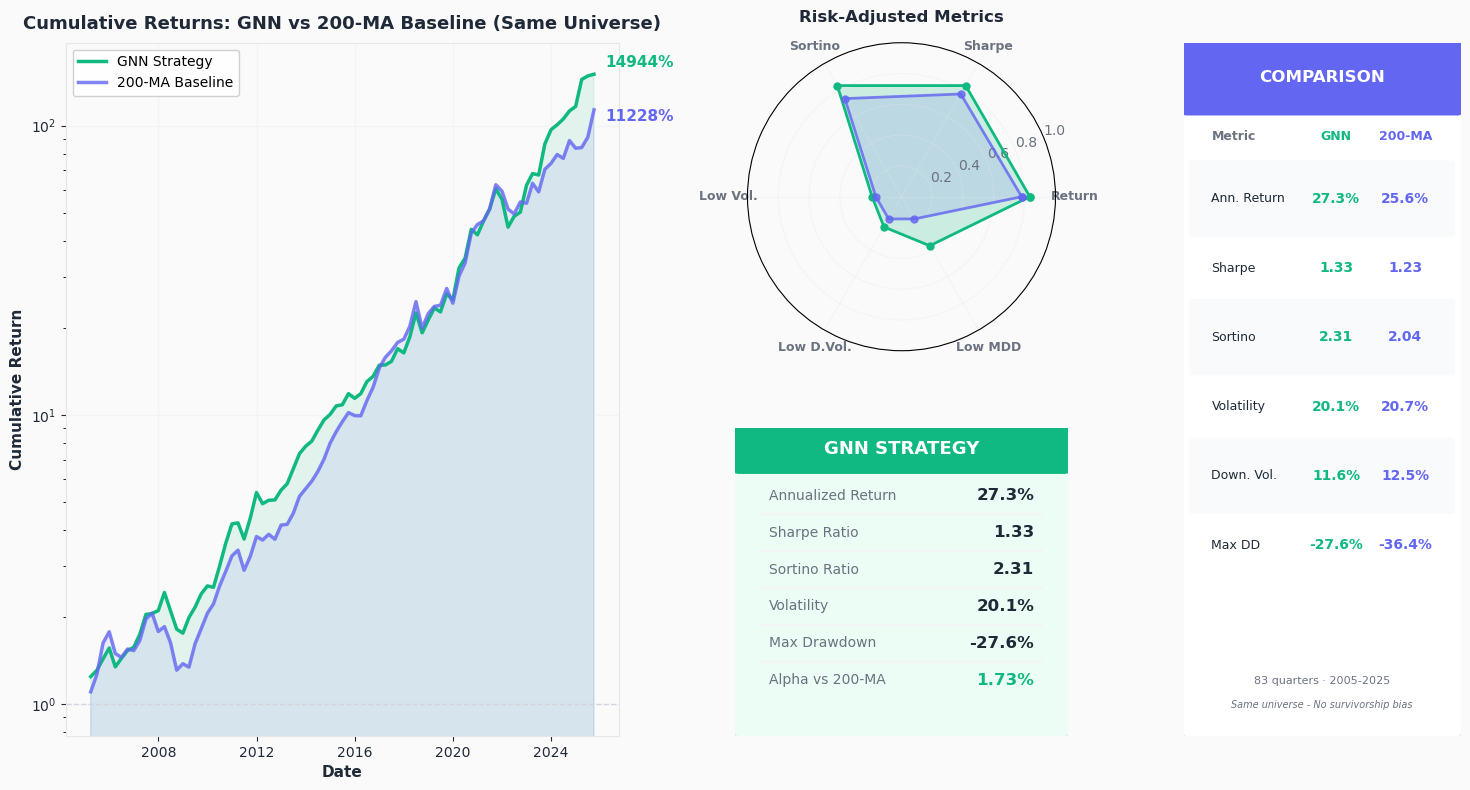


VISUALIZATION SAVED
gnn_vs_200ma_comparison.png - Fair Comparison Dashboard


In [75]:
# ============================================================================
# COMBINED FIGURE: GNN vs 200-MA Baseline (Same Universe)
# ============================================================================

# Colors
STRATEGY_COLOR = '#10b981'  # Green for GNN
MA_COLOR = '#6366f1'        # Blue for 200-MA
BG_COLOR = '#fafafa'
CARD_BG = '#ffffff'
TEXT_DARK = '#1f2937'
TEXT_MUTED = '#6b7280'

# Create figure
fig = plt.figure(figsize=(18, 9), facecolor=BG_COLOR)
gs = gridspec.GridSpec(2, 3, width_ratios=[2, 1.2, 1], height_ratios=[1, 1], 
                       hspace=0.25, wspace=0.3)

# ============================================================================
# TOP LEFT: Cumulative Returns (spans 2 rows)
# ============================================================================
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_facecolor(BG_COLOR)

ax1.plot(dates, gnn_cumulative, linewidth=2.5, color=STRATEGY_COLOR, label='GNN Strategy')
ax1.plot(dates, ma_cumulative, linewidth=2.5, color=MA_COLOR, label='200-MA Baseline', alpha=0.8)
ax1.fill_between(dates, gnn_cumulative, alpha=0.1, color=STRATEGY_COLOR)
ax1.fill_between(dates, ma_cumulative, alpha=0.1, color=MA_COLOR)
ax1.axhline(y=1, color='#d1d5db', linestyle='--', linewidth=1)
ax1.set_ylabel('Cumulative Return', fontsize=11, fontweight='bold', color=TEXT_DARK)
ax1.set_xlabel('Date', fontsize=11, fontweight='bold', color=TEXT_DARK)
ax1.set_title('Cumulative Returns: GNN vs 200-MA Baseline (Same Universe)', fontsize=13, fontweight='bold', color=TEXT_DARK, pad=10)
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, color='#e5e7eb')
ax1.set_yscale('log')
ax1.tick_params(colors=TEXT_DARK)

final_gnn = gnn_cumulative[-1]
final_ma = ma_cumulative[-1]
ax1.annotate(f'{(final_gnn-1)*100:.0f}%', xy=(dates[-1], final_gnn), 
            xytext=(8, 5), textcoords='offset points', fontsize=11, fontweight='bold', color=STRATEGY_COLOR)
ax1.annotate(f'{(final_ma-1)*100:.0f}%', xy=(dates[-1], final_ma), 
            xytext=(8, -8), textcoords='offset points', fontsize=11, fontweight='bold', color=MA_COLOR)

for spine in ax1.spines.values():
    spine.set_color('#e5e7eb')

# ============================================================================
# TOP RIGHT: Radar Chart
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1], polar=True, facecolor=BG_COLOR)

categories = ['Return', 'Sharpe', 'Sortino', 'Low Vol.', 'Low D.Vol.', 'Low MDD']
strategy_metrics_raw = [
    gnn_annualized_return * 100, gnn_sharpe, gnn_sortino,
    gnn_volatility_annual * 100, gnn_downside_vol_annual * 100, abs(gnn_max_dd) * 100
]
ma_metrics_raw = [
    ma_annualized_return * 100, ma_sharpe, ma_sortino,
    ma_annual_vol * 100, ma_downside_vol * 100, abs(ma_max_dd) * 100
]

def normalize_metrics(strategy, baseline):
    norm_s, norm_b = [], []
    for i, (s, b) in enumerate(zip(strategy, baseline)):
        max_val = max(abs(s), abs(b)) * 1.2
        if i < 3:  # Higher is better
            norm_s.append(s / max_val)
            norm_b.append(b / max_val)
        else:  # Lower is better
            norm_s.append(1 - s / max_val)
            norm_b.append(1 - b / max_val)
    return norm_s, norm_b

strategy_norm, ma_norm = normalize_metrics(strategy_metrics_raw, ma_metrics_raw)
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]
strategy_norm += strategy_norm[:1]
ma_norm += ma_norm[:1]

ax2.plot(angles, strategy_norm, 'o-', linewidth=2, color=STRATEGY_COLOR, label='GNN', markersize=5)
ax2.fill(angles, strategy_norm, alpha=0.2, color=STRATEGY_COLOR)
ax2.plot(angles, ma_norm, 'o-', linewidth=2, color=MA_COLOR, label='200-MA', markersize=5, alpha=0.8)
ax2.fill(angles, ma_norm, alpha=0.15, color=MA_COLOR)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=9, fontweight='bold', color=TEXT_DARK)
ax2.set_ylim(0, 1)
ax2.set_title('Risk-Adjusted Metrics', fontsize=12, fontweight='bold', color=TEXT_DARK, pad=15)
ax2.grid(True, alpha=0.3, color='#e5e7eb')
ax2.tick_params(colors=TEXT_MUTED)

# ============================================================================
# BOTTOM RIGHT: GNN Strategy Card
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)
ax3.axis('off')
ax3.set_facecolor(BG_COLOR)

# Card background
card = FancyBboxPatch((0.2, 0.2), 9.6, 9.6, boxstyle="round,rounding_size=0.4",
                       facecolor='#ecfdf5', edgecolor='#e5e7eb', linewidth=1.5)
ax3.add_patch(card)

# Accent bar
accent = FancyBboxPatch((0.2, 8.8), 9.6, 1.0, boxstyle="round,rounding_size=0.2",
                         facecolor=STRATEGY_COLOR, edgecolor='none')
ax3.add_patch(accent)

ax3.text(5, 9.3, 'GNN STRATEGY', fontsize=13, fontweight='bold', color='white', ha='center', va='center')

# Calculate alpha vs 200-MA
alpha_vs_ma = (gnn_annualized_return - ma_annualized_return)

metrics = [
    ('Annualized Return', f'{gnn_annualized_return*100:.1f}%'),
    ('Sharpe Ratio', f'{gnn_sharpe:.2f}'),
    ('Sortino Ratio', f'{gnn_sortino:.2f}'),
    ('Volatility', f'{gnn_volatility_annual*100:.1f}%'),
    ('Max Drawdown', f'{gnn_max_dd*100:.1f}%'),
    ('Alpha vs 200-MA', f'{alpha_vs_ma*100:.2f}%'),
]

y_start = 7.8
y_spacing = 1.2

for i, (label, value) in enumerate(metrics):
    y = y_start - i * y_spacing
    if i > 0:
        ax3.plot([0.8, 9.2], [y + 0.6, y + 0.6], color='#f3f4f6', linewidth=1.5)
    ax3.text(1, y, label, fontsize=10, color=TEXT_MUTED, ha='left', va='center')
    value_color = STRATEGY_COLOR if i == 5 else TEXT_DARK
    ax3.text(9, y, value, fontsize=12, fontweight='bold', color=value_color, ha='right', va='center')

# ============================================================================
# FAR RIGHT: Comparison Table
# ============================================================================
ax4 = fig.add_subplot(gs[:, 2])
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 20)
ax4.axis('off')
ax4.set_facecolor(BG_COLOR)

# Card background
card2 = FancyBboxPatch((0.2, 0.2), 9.6, 19.6, boxstyle="round,rounding_size=0.4",
                        facecolor=CARD_BG, edgecolor='#e5e7eb', linewidth=1.5)
ax4.add_patch(card2)

# Header
header = FancyBboxPatch((0.2, 18.2), 9.6, 1.6, boxstyle="round,rounding_size=0.2",
                         facecolor=MA_COLOR, edgecolor='none')
ax4.add_patch(header)
ax4.text(5, 19, 'COMPARISON', fontsize=12, fontweight='bold', color='white', ha='center', va='center')

# Table headers
ax4.text(1, 17.2, 'Metric', fontsize=9, fontweight='bold', color=TEXT_MUTED, ha='left')
ax4.text(5.5, 17.2, 'GNN', fontsize=9, fontweight='bold', color=STRATEGY_COLOR, ha='center')
ax4.text(8, 17.2, '200-MA', fontsize=9, fontweight='bold', color=MA_COLOR, ha='center')

table_metrics = [
    ('Ann. Return', f'{gnn_annualized_return*100:.1f}%', f'{ma_annualized_return*100:.1f}%'),
    ('Sharpe', f'{gnn_sharpe:.2f}', f'{ma_sharpe:.2f}'),
    ('Sortino', f'{gnn_sortino:.2f}', f'{ma_sortino:.2f}'),
    ('Volatility', f'{gnn_volatility_annual*100:.1f}%', f'{ma_annual_vol*100:.1f}%'),
    ('Down. Vol.', f'{gnn_downside_vol_annual*100:.1f}%', f'{ma_downside_vol*100:.1f}%'),
    ('Max DD', f'{gnn_max_dd*100:.1f}%', f'{ma_max_dd*100:.1f}%'),
]

y_start = 15.5
y_spacing = 2.0

for i, (label, strat_val, ma_val) in enumerate(table_metrics):
    y = y_start - i * y_spacing
    
    # Alternating row background
    if i % 2 == 0:
        row_bg = FancyBboxPatch((0.5, y - 0.8), 9, 1.6, boxstyle="round,rounding_size=0.1",
                                 facecolor='#f9fafb', edgecolor='none')
        ax4.add_patch(row_bg)
    
    ax4.text(1, y, label, fontsize=9, color=TEXT_DARK, ha='left', va='center')
    ax4.text(5.5, y, strat_val, fontsize=10, fontweight='bold', color=STRATEGY_COLOR, ha='center', va='center')
    ax4.text(8, y, ma_val, fontsize=10, fontweight='bold', color=MA_COLOR, ha='center', va='center')

# Footer
ax4.text(5, 1.5, f'{min_len} quarters · 2005-2025', fontsize=8, color=TEXT_MUTED, ha='center')
ax4.text(5, 0.8, 'Same universe - No survivorship bias', fontsize=7, color=TEXT_MUTED, ha='center', style='italic')

plt.tight_layout()
plt.savefig('gnn_vs_200ma_comparison.png', dpi=300, bbox_inches='tight', facecolor=BG_COLOR)
plt.show()

print("\n" + "="*70)
print("VISUALIZATION SAVED")
print("="*70)
print("gnn_vs_200ma_comparison.png - Fair Comparison Dashboard")

In [76]:
from scipy import stats

print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE OF ALPHA")
print("="*80)

# Calculate excess returns (alpha) for each quarter
excess_returns = gnn_returns_aligned - ma_returns_aligned

# Basic statistics on excess returns
alpha_mean = np.mean(excess_returns)
alpha_std = np.std(excess_returns, ddof=1)
alpha_se = alpha_std / np.sqrt(len(excess_returns))

# T-statistic: Is the mean excess return significantly different from zero?
t_stat = alpha_mean / alpha_se
degrees_of_freedom = len(excess_returns) - 1

# Two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), degrees_of_freedom))

# Annualized alpha
alpha_annualized = alpha_mean * 4

print(f"\nHypothesis Test (H0: Alpha = 0):")
print(f" T-statistic:             {t_stat:>8.3f}")
print(f" Degrees of freedom:      {degrees_of_freedom:>8.0f}")
print(f" P-value (two-tailed):    {p_value:>8.5f}")

# Information Ratio
information_ratio = alpha_mean / alpha_std * np.sqrt(4)  # Annualized
print(f"\nInformation Ratio: {information_ratio:.3f}")



STATISTICAL SIGNIFICANCE OF ALPHA

Hypothesis Test (H0: Alpha = 0):
 T-statistic:                0.367
 Degrees of freedom:            82
 P-value (two-tailed):     0.71485

Information Ratio: 0.080
